In [1]:
import sys,os
import csv
import pickle
import scipy
import numpy as np
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
import sklearn.model_selection
import sklearn.feature_extraction
import itertools
import json
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd
from train_configurations import *

# Feature Importance

In this nb we will use the __shap__ python package to compute the shap values of the models trained with the 01_train_all_models.py script.

In the __Configuration__ section, fill the "nations_params" dictionary with the kind of classifier used for the corresponding nation, the target score used in the Grid Search and the seed for the random number generators. Check "training_results.json" for possible values.

The final figures will be saved into the __/figures__ folder under the name of "shap_values_{selected nation}.png"


# Configurations

In [2]:
nations_params ={
    "IT":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "FR":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "ES":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "DE":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "AT":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "NL":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "IT_speeches":{
        "model":"GradientBoosting",
        "target": "AUC",
        "random_state":1
    },
    "IT_manual":{
        "model":"GradientBoosting",
        "target": "F1",
        "random_state":1
    },
}

nation_labels = {
    "IT":"Italy",
    "IT_manual":"Italy Manual Coding",
    "IT_speeches":"Italy Leader Speeches",
    "AT": "Austria",
    "DE": "Germany",
    "FR": "France",
    "NL": "Netherlands",
    "ES": "Spain"
}
    

nations = list(nations_params.keys())
numbers = [str(n) for n in range(1000)]
p_train = 0.7


def cut_words(w_list):
    return [w for w in w_list if len(w)>2 and w not in numbers]


# Shap-Values

In [3]:
def compute_shap_values(nation,nations_params=nations_params):
    print("reading model for {}...".format(nation))
    model_type, target, random_state = nations_params[nation].values()
    params = pickle.load(open("./models/{0}_{1}_{2}_{3}_best_model_params.pkl".format(nation, model_type, target, random_state),'rb'))
    model = pickle.load(open("./models/{0}_{1}_{2}_{3}_best_model.pkl".format(nation, model_type, target, random_state),"rb"))
    max_thresh = params["threshold"]

    if nation in ["IT_speeches","IT_manual"]:
        data = json.load(open("./datasets/{}_sentences.json".format(nation),"r"))        
    else:
        data = json.load(open("./datasets/{}_manifesto_sentences.json".format(nation),"r"))

    texts = np.array([cut_words(record["clean_text"]) for record in data])
    texts = np.array([" ".join(sent) for sent in texts])

    parties = np.array([record["party"] for record in data])
    years = np.array([record["party"] for record in data])
    orientations = np.array([record["orientation"] for record in data])
    texts_train,texts_test = sklearn.model_selection.train_test_split(texts,random_state=random_state, test_size=1-p_train)

    vectorizer = sklearn.feature_extraction.text.CountVectorizer()
    X_train = (vectorizer.fit_transform(texts_train)>0).astype(int).toarray()
    X_test = (vectorizer.transform(texts_test)>0).astype(int).toarray()  


    X_test = pd.DataFrame(X_test)
    
    index2words = {index:w for w,index in vectorizer.vocabulary_.items()}
    X_test.columns = list(index2words[n] for n in range(len(index2words)))

    X_train = pd.DataFrame(X_train)
    X_train.columns = list(index2words[n] for n in range(len(index2words)))

    explainer = shap.Explainer(model, approximate=True)
    shap_values = explainer(X_test)
    
    return shap_values

reading model for IT...


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


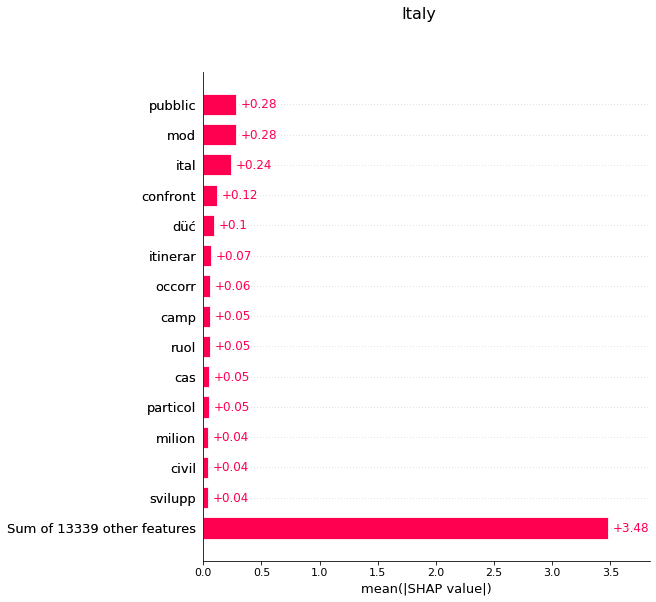

reading model for IT_manual...


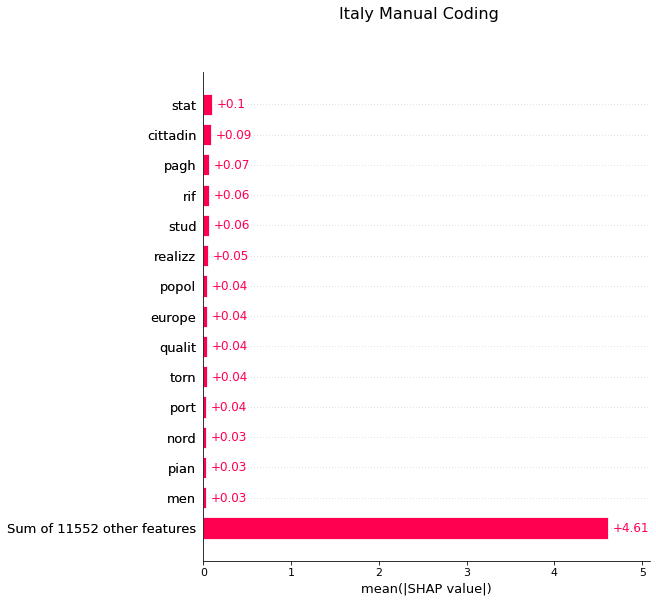

reading model for IT_speeches...


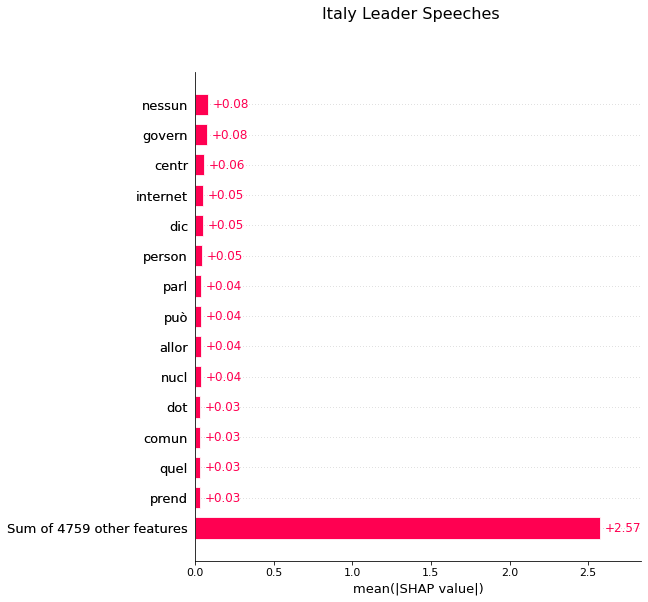

reading model for FR...


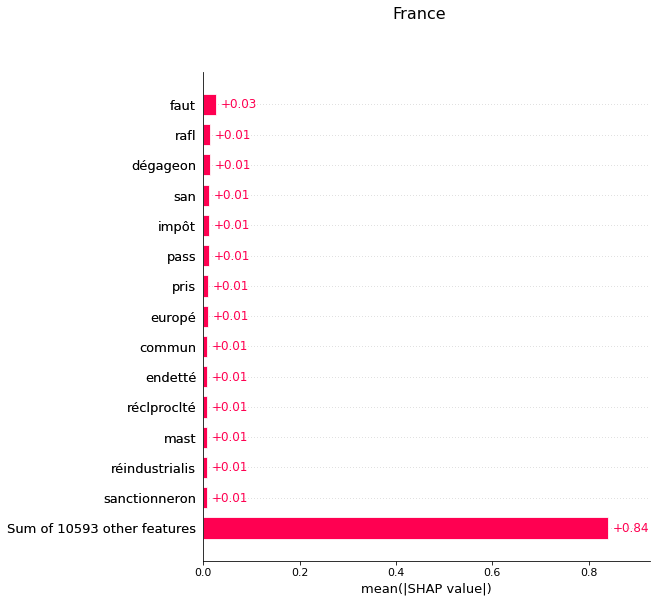

reading model for ES...


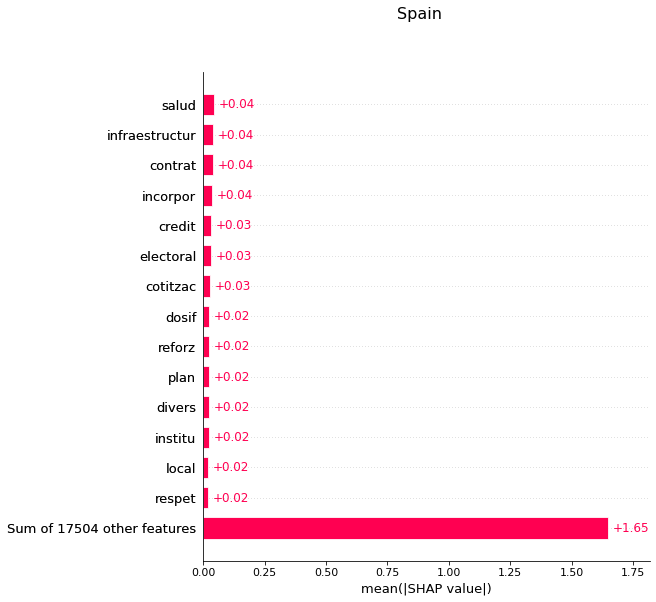

reading model for AT...


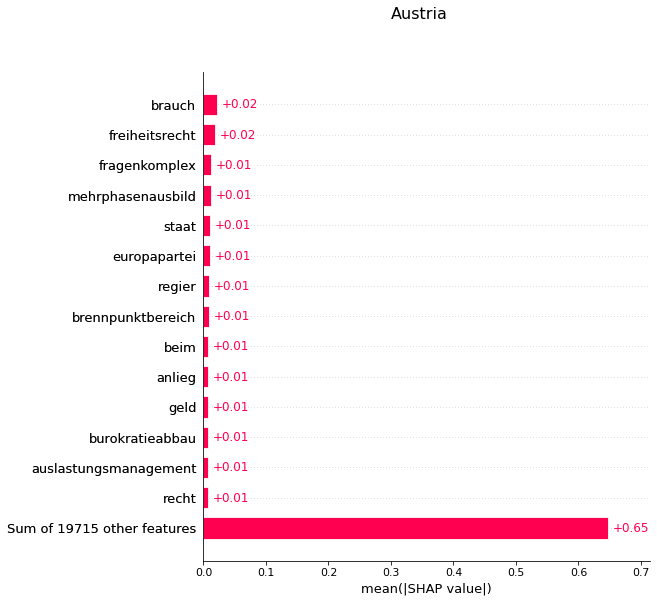

reading model for DE...


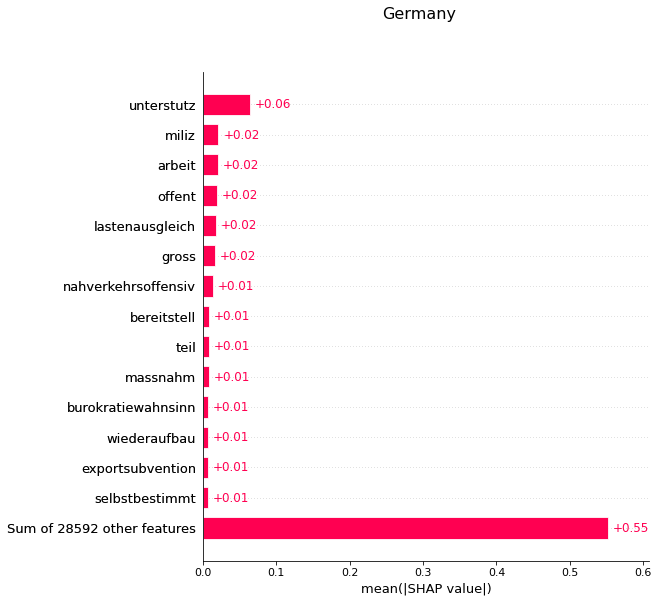

reading model for NL...


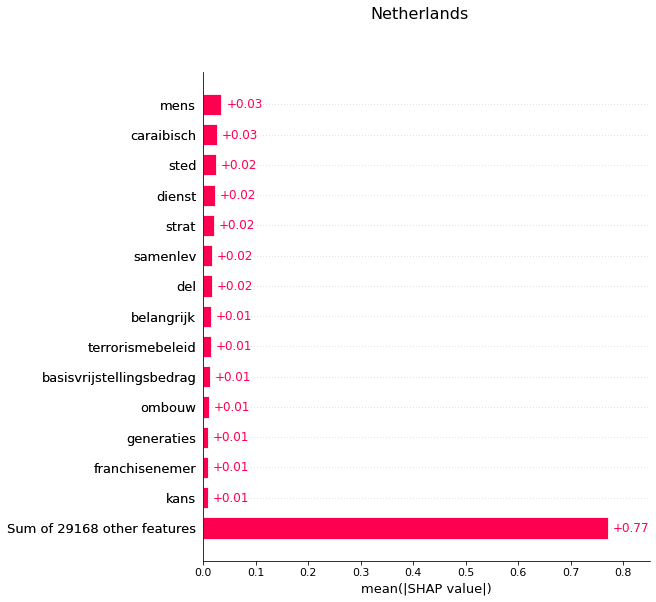

In [4]:
for nation in ["IT", "IT_manual", "IT_speeches", "FR", "ES", "AT","DE","NL"]:

    fig = plt.figure(figsize=(20,5))   
    fig.suptitle(nation_labels[nation], fontsize=16)
    shap_values = compute_shap_values(nation)
    shap.plots.bar(shap_values, show=False,max_display=15)
    plt.savefig("./figures/shap_values_{}.png".format(nation), dpi=300)
    plt.show()